In [36]:
%matplotlib notebook
from IPython.display import Image

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [37]:
import h5py
import torch
import numpy as np

from sklearn import decomposition

from orthonet import jacob

## Quickly check out data

<IPython.core.display.Javascript object>


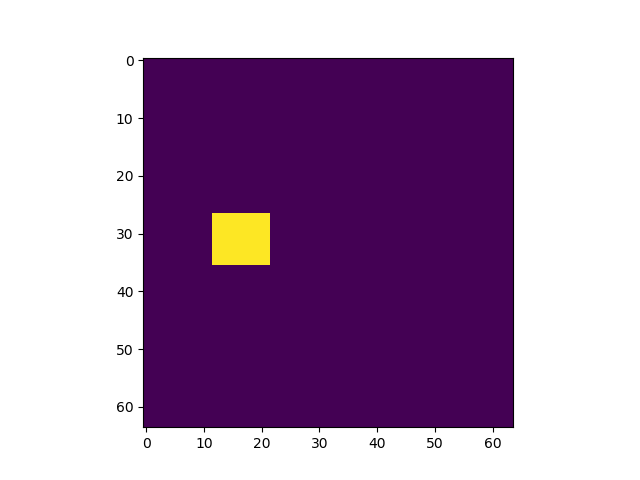

[[0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 2]]
[[1.         1.         0.5        0.         0.         0.        ]
 [1.         1.         0.5        0.         0.         0.03225806]
 [1.         1.         0.5        0.         0.         0.06451613]]


In [38]:
BASE_PATH = '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/sprites/'

df = h5py.File(BASE_PATH + 'dsprites.h5', 'r')
original_data = np.array(df['imgs'][:1028])
classes = np.array(df['latents/classes'])
values  = np.array(df['latents/values'])
df.close()

plt.figure()
plt.imshow(original_data[47])
plt.show()

print(classes[:3])
print(values[:3])

### Load Data & Model

In [18]:
def load_model(model_path, original_data):

    model = torch.load(model_path + '/model.pt')

    ot = torch.tensor(original_data.astype(np.float32))
    latent = model.encode(ot).detach().numpy()
    recon  = model(ot)

    # deals with VAE case where I also saved logvar, use only mu here
    if type(recon) == tuple:
        recon = recon[0].detach().numpy()
    else:
        recon = recon.detach().numpy()

    return model, latent, recon

MODEL_PATH = BASE_PATH + 'ortho_spritesvae-1.00e+00_ob1.00e+00_db1.00e+00'
model, latent, recon = load_model(MODEL_PATH, original_data)

### Take a look at the training curves and direct latent space

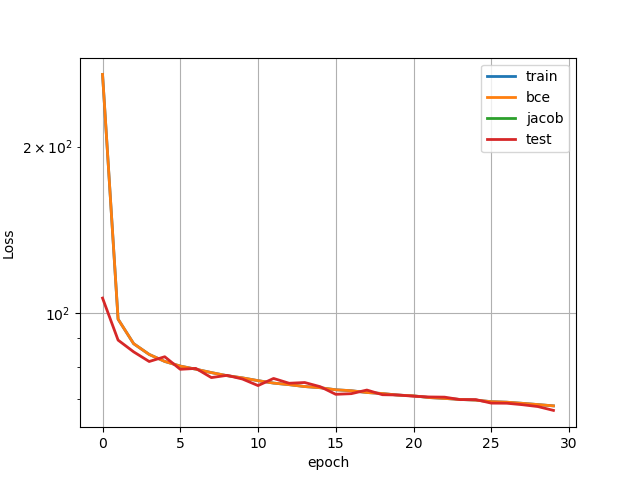

In [39]:
Image(filename=MODEL_PATH + '/loss_curves.png')

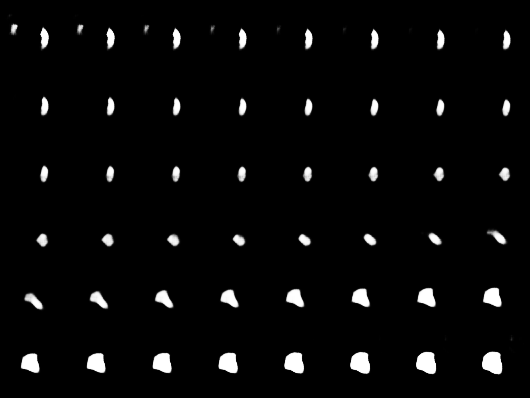

In [40]:
Image(filename=MODEL_PATH + '/z0.png')

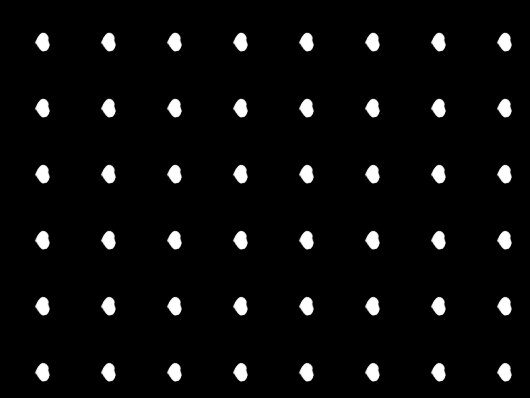

In [41]:
Image(filename=MODEL_PATH + '/z1.png')

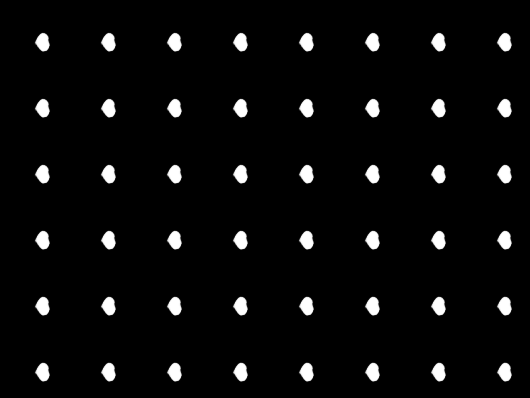

In [42]:
Image(filename=MODEL_PATH + '/z2.png')

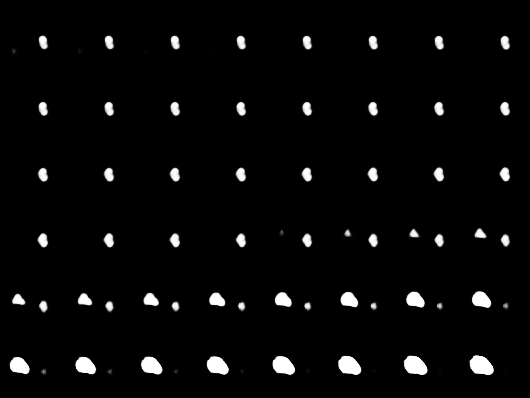

In [43]:
Image(filename=MODEL_PATH + '/z3.png')

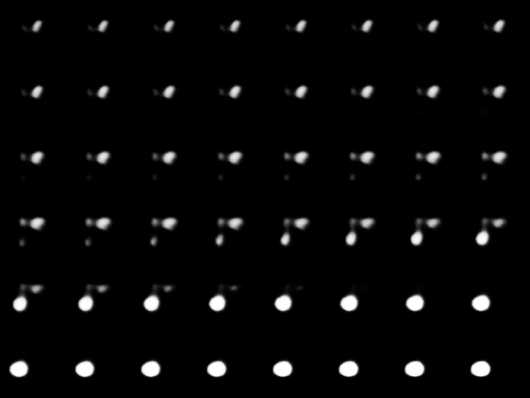

In [26]:
Image(filename=MODEL_PATH + '/z4.png')

### PCA Analysis of Latent Space

<IPython.core.display.Javascript object>


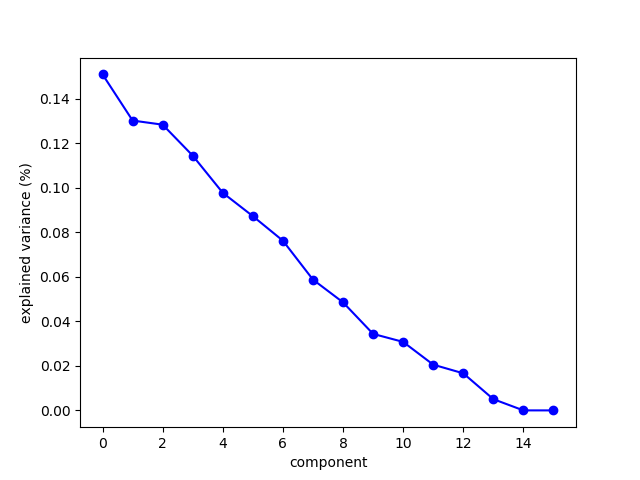

In [44]:
n_components = latent.shape[1]

pca = decomposition.PCA(n_components=n_components)
pca.fit(latent)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.plot(pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

(1028, 16)


<IPython.core.display.Javascript object>


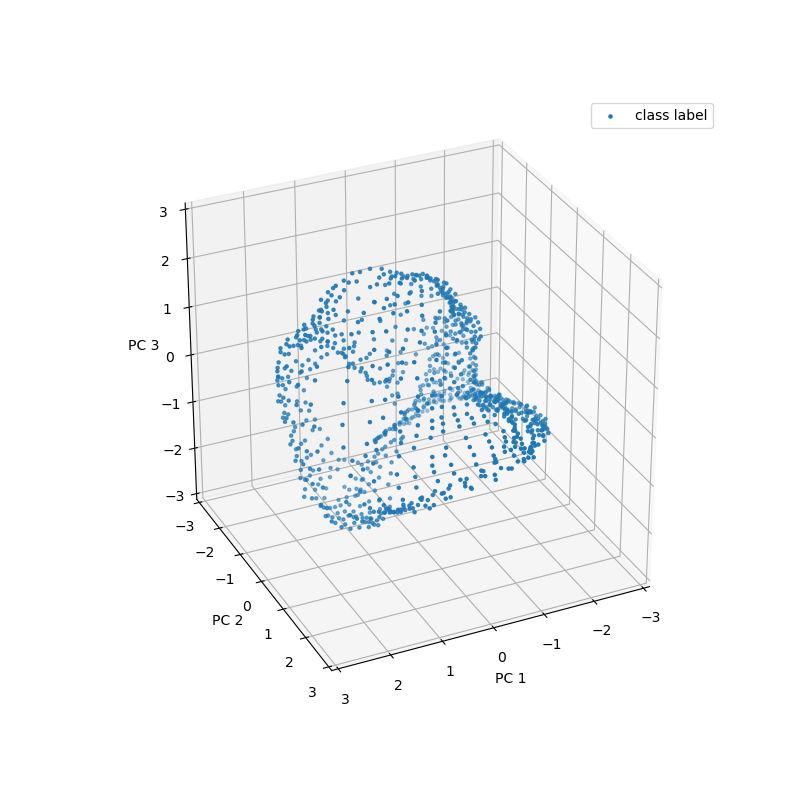

In [45]:
max_pts = 1280
l = 3 # plot limits

latent_in_pc = pca.transform(latent)
print(latent_in_pc.shape)

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['class label'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])

plt.savefig(MODEL_PATH+'/latent.pdf')
plt.show()

### Direct look at the Jacobian of the resulting network

In [32]:
n_samples = 128
n_outputs = torch.tensor(np.product(original_data.shape[1:]))

J = np.zeros([64*64, latent.shape[1]])
for i in range(n_samples):
    Jx = jacob.jacobian(model.decode, torch.tensor(latent[i]), n_outputs)
    J += Jx.detach().numpy()

<IPython.core.display.Javascript object>


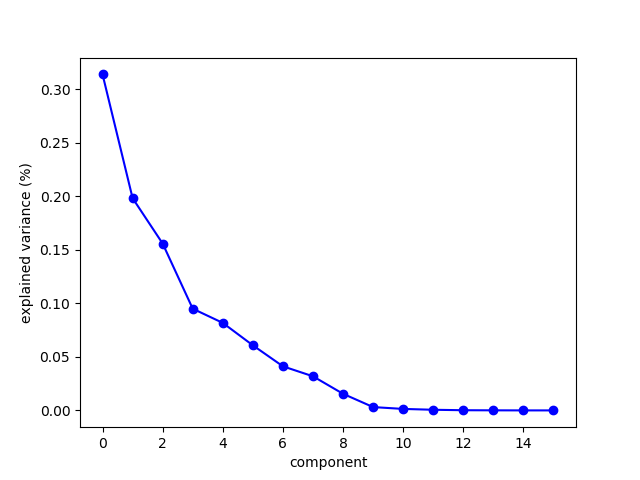

In [33]:
J_pca = decomposition.PCA(n_components=J.shape[1])
J_pca.fit(J)

plt.figure()
plt.plot(J_pca.explained_variance_ratio_, 'bo')
plt.plot(J_pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

<IPython.core.display.Javascript object>


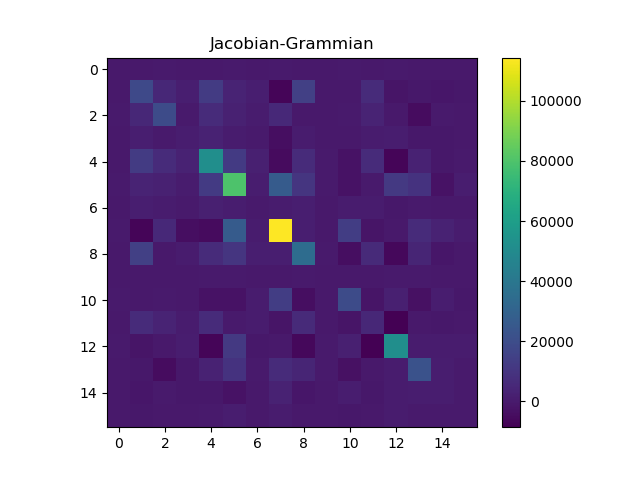

In [35]:
JG = np.dot(J.T, J)

plt.figure()
plt.title('Jacobian-Grammian')
plt.imshow(JG)

# for (j,i),label in np.ndenumerate(JG):
#     plt.text(i, j, np.round(label,2), ha='center', va='center', color='w')

plt.colorbar()
    
plt.show()